In [21]:
import pandas as pd
from utils import *
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt,figure 
from venn import venn

# Tratamento da base de dados

In [22]:
df = sheet_to_parquet(['./RelatorioExportacaoGeral_4-1-2023.xlsx'])
df.Enquadramento = df.Enquadramento.astype(bool)
df = df[df.Enquadramento]

Lendo arquivo: ./Parquets/RelatorioExportacaoGeral_4-1-2023.gzip


## Transforma descrições em números inteiros

In [23]:
# EHNA - Estruturas habitadas não afetadas: DescImpactoSocioEconomico == 0
# DEM - Danos econômicos mínimos: DescImpactoSocioEconomico <= 1

# SPHP - Sem perda Humana Provável: DescProbabilidadeMorte == 0

# ILR - Impactos limitados para áreas rurais, acrícolas ou não urbanizadas:  DescImpactoSocioEconomico <= 1

# Propoem-se:
    # Remover ILR e alterar definição:
        # DEM - Danos econômicos mínimos e impactos limitados para áreas rurais, acrícolas ou não urbanizadas: DescImpactoSocioEconomico <= 1

dict_impacto_economico_value = {
    'INEXISTENTE ( não existem quaisquer instalações e serviços de navegação na área afetada por acidente da barragem)': 0,
    "BAIXO ( existe pequena concentração de instalações residenciais e comerciais, agrícolas, industriais ou de infraestrutura  na área afetada da barragem ou instalações portuárias ou serviços de navegação" : 1,
    'ALTO (existe grande concentração de  instalações residenciais e comerciais, agrícolas, industriais, de infraestrutura e serviços de lazer e turismo na área afetada da barragem ou instalações portuárias ou serviços de navegação)':2,
}
df.DescImpactoSocioEconomico = df.DescImpactoSocioEconomico.map(dict_impacto_economico_value).astype(int)


dict_prob_morte_value = {
    'INEXISTENTE (não existem pessoas permanentes/residentes ou temporárias/transitando na área afetada a  jusante da barragem)': 0,
    'POUCO FREQUENTE (não existem pessoas ocupando permanentemente a área afetada a  jusante da barragem, mas existe estrada vicinal de uso local)' : 1,
    'EXISTENTE (existem pessoas ocupando permanentemente a área afetada a  jusante da barragem, portanto, vidas humanas poderão ser atingidas)':2,
    'FREQUENTE  (não existem pessoas ocupando permanentemente a área afetada a jusante da barragem, mas existe rodovia municipal, estadual, federal ou outro local e/ou empreendimento de permanência eventual de pessoas que poderão ser atingidas)':3
}


df.DescProbabilidadeMorte = df.DescProbabilidadeMorte.map(dict_prob_morte_value).astype(int)


# Não foi usado
dict_impacto_ambiental_value = {
    'SIGNIFICATIVO (área afetada da barragem não representa área de interesse ambiental, áreas protegidas em legislação específica ou encontra-se totalmente descaracterizada de suas condições naturais)':0,
    'MUITO SIGNIFICATIVO (área afetada da barragem apresenta interesse ambiental relevante ou protegida em legislação específica)': 1,
}

df.DescImpactoAmbiental  = df.DescImpactoAmbiental.map(dict_impacto_ambiental_value).astype(int)


In [24]:
list_cols_medidas = ['MdaAlturaMacicoTerreno','MdaCapacidadeTotalEmpreendimento']
for col in list_cols_medidas:
    df[col] = df[col].str.replace(",","").astype(float) / 1e6 #converte de hm^3 para m^3

In [25]:
list_cols_criterios = ['DescImpactoSocioEconomico','DescProbabilidadeMorte','DescImpactoAmbiental']
list_cols_max_criterios = (list_cols_criterios + list_cols_medidas)

dict_max_criterios = {}
for col in list_cols_max_criterios:
    dummy = df[['IdeUsina',col]]
    dummy = dummy.loc[dummy.groupby('IdeUsina')[col].idxmax()]
    dict_max_criterios[col] = dummy

In [26]:
df = df[['IdeUsina']].drop_duplicates(ignore_index=True) #,'NomeUsina'

In [27]:
for col in list_cols_max_criterios:
    df = df.merge(dict_max_criterios[col],on='IdeUsina',how='left')
del dict_max_criterios

# Cria definições: DEM, SPHP e ILR

In [28]:
list_col_casos = ['DEM','SPHP','EHNA']

df['DEM'] = False
df.loc[df.DescImpactoSocioEconomico<=1, 'DEM'] = True

df['SPHP'] = False
df.loc[df.DescProbabilidadeMorte==0, 'SPHP'] = True


df['EHNA'] = False
df.loc[((df.DescImpactoSocioEconomico == 0)), 'EHNA'] = True

df[["IdeUsina"] + list_cols_criterios + list_col_casos].sample(5)

,IdeUsina,DescImpactoSocioEconomico,DescProbabilidadeMorte,DescImpactoAmbiental,DEM,SPHP,EHNA
283,37437,1,1,0,True,False,False
244,1498,2,2,0,False,False,False
394,35297,2,2,0,False,False,False
48,31428,1,3,0,True,False,False
446,2146,2,2,0,False,False,False


# Cria definições quantitativas

In [29]:
df["Quantitativo_B"] = ~((df.MdaCapacidadeTotalEmpreendimento > 493_200) &  (df.MdaAlturaMacicoTerreno > 12.2))

df["Quantitativo_MBB"] = (((df.MdaCapacidadeTotalEmpreendimento >= 61_650) &  (df.MdaAlturaMacicoTerreno < 1.8))|
                        ((df.MdaCapacidadeTotalEmpreendimento < 61_650) &  (df.MdaAlturaMacicoTerreno < 7.6))
                        )
df["Quantitativo_MBM"] = ((df.MdaCapacidadeTotalEmpreendimento < 18_495) &  (df.MdaAlturaMacicoTerreno   < 4.6))

df["Quantitativo_MBA"] = ((df.MdaCapacidadeTotalEmpreendimento < 61_650) |  (df.MdaAlturaMacicoTerreno   < 7.6))
list_col_casos_quantivativos_MB = ['Quantitativo_MBB','Quantitativo_MBM','Quantitativo_MBA']

df["Quantitativo_MB"] = df[list_col_casos_quantivativos_MB].any(axis=1)
df = df.drop(list_col_casos_quantivativos_MB, axis=1)

list_col_casos_quantivativos = ['Quantitativo_B','Quantitativo_MB']

# Diagrama de Venn

,DEM,SPHP,EHNA,Quantidade
0,True,False,False,232
1,False,False,False,202
2,True,False,True,60
3,True,True,True,38
4,True,True,False,5
5,False,True,False,3


,DEM,SPHP,EHNA,Quantidade
0,True,False,False,232
2,True,False,True,60
3,True,True,True,38
4,True,True,False,5
5,False,True,False,3


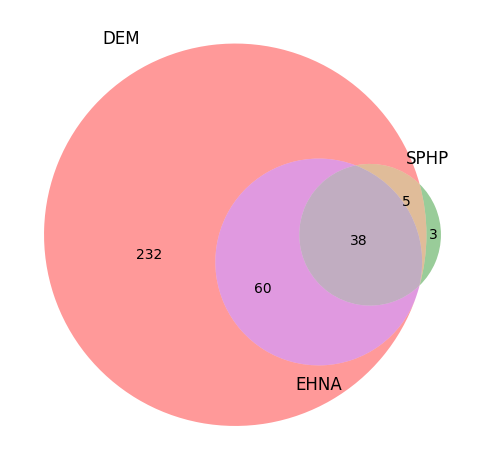

In [30]:
casos = df[list_col_casos].value_counts().reset_index().rename(columns={0: "Quantidade"})
dict_cont_casos = {}
display(casos)

# Remove casos que todos os critérios são falsos
casos = casos[casos[list_col_casos].any(axis=1)]

display(casos)
casos["String"] = ""


for col in list_col_casos:
        casos.loc[casos[col], "String"] = casos["String"] + '1'
        casos.loc[~casos[col], "String"] = casos["String"] + '0'
venn_subsets = dict(zip(casos.String,casos.Quantidade))


plt.figure(figsize=(6,6), facecolor="white")
venn3(
    subsets=venn_subsets,
    set_labels = list_col_casos,
)

plt.savefig("venn.png")

# Diagrama de Venn (2)

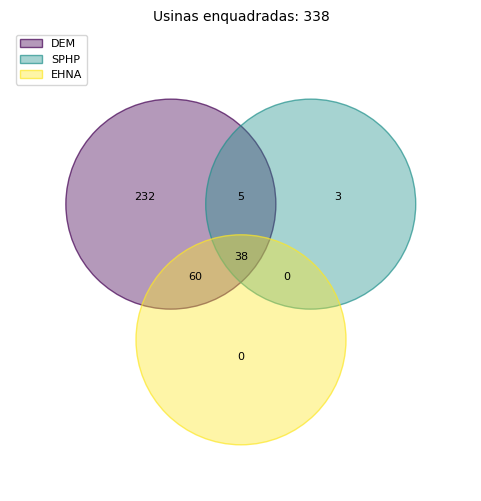

In [37]:
dict_venn = {}
mask_quant= ~( df.IdeUsina == df.IdeUsina)

for col in (list_col_casos):
    mask = df[col]
    mask_quant |= mask
    dict_venn[col] = set(df[mask].IdeUsina)
quant = mask_quant[mask_quant].shape[0]
fig, ax = plt.subplots(figsize=(6, 6),dpi=100)
venn(dict_venn, fontsize=8, legend_loc="upper left",ax=ax)
ax.set_title(f"Usinas enquadradas: {quant}",fontdict={'color':'black','size':10})
fig.patch.set_facecolor('white')
fig.savefig("venn.png")

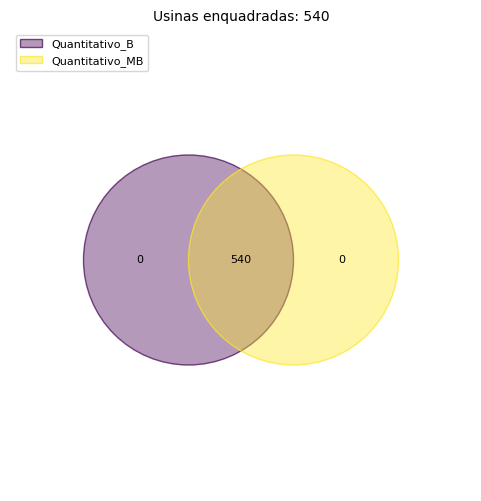

In [32]:
dict_venn = {}
mask_quant= ~( df.IdeUsina == df.IdeUsina)

for col in (list_col_casos_quantivativos):
    mask = df[col]
    mask_quant |= mask
    dict_venn[col] = set(df[mask].IdeUsina)
quant = mask_quant[mask_quant].shape[0]
fig, ax = plt.subplots(figsize=(6, 6),dpi=100)
ax.set_title(f"Usinas enquadradas: {quant}",fontdict={'color':'black','size':10})
venn(dict_venn, fontsize=8, legend_loc="upper left",ax=ax)
fig.patch.set_facecolor('white')
fig.savefig("venn2.png")

In [33]:
df["Quantitativo"] = df["Quantitativo_B"] & df["Quantitativo_MB"]

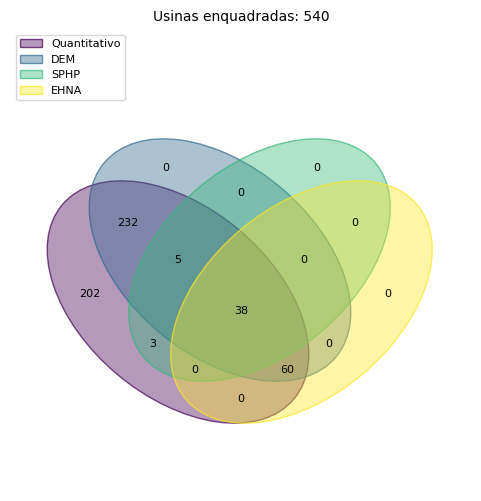

In [34]:
dict_venn = {}
mask_quant= ~( df.IdeUsina == df.IdeUsina)

for col in (["Quantitativo"]+list_col_casos):
    mask = df[col]
    mask_quant |= mask
    dict_venn[col] = set(df[mask].IdeUsina)
quant = mask_quant[mask_quant].shape[0]
fig, ax = plt.subplots(figsize=(6, 6),dpi=100)
ax.set_title(f"Usinas enquadradas: {quant}",fontdict={'color':'black','size':10})
venn(dict_venn, fontsize=8, legend_loc="upper left",ax=ax)
fig.patch.set_facecolor('white')
fig.savefig("venn3.png")

In [35]:
from itertools import combinations, permutations

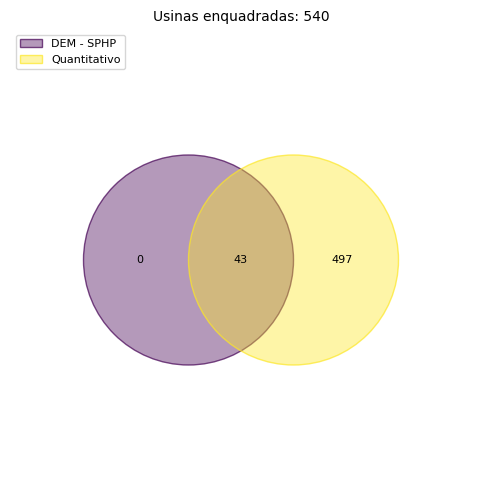

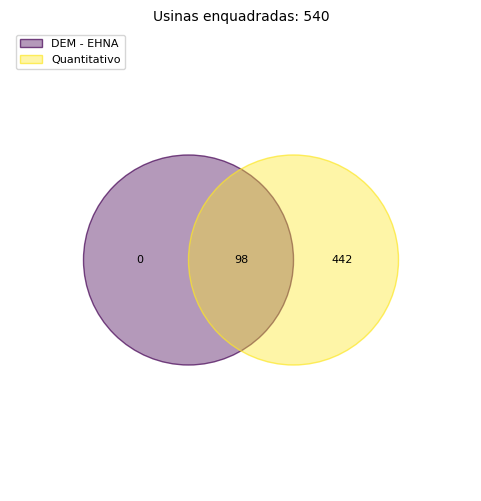

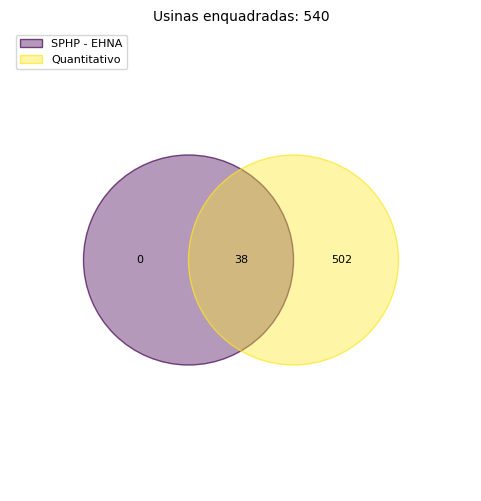

In [36]:
for k,(col1,col2) in enumerate(combinations(list_col_casos,2)):
    dict_venn = {}
    mask_quant= ~( df.IdeUsina == df.IdeUsina)
    mask = df[col1] & df[col2]
    mask_quant |= mask
    dict_venn[f'{col1} - {col2}'] = set(df[mask & df.Quantitativo].IdeUsina)

    dict_venn['Quantitativo'] = set(df[df.Quantitativo].IdeUsina)

    fig, ax = plt.subplots(figsize=(6, 6),dpi=100)
    ax.set_title(f"Usinas enquadradas: {quant}",fontdict={'color':'black','size':10})
    venn(dict_venn, fontsize=8, legend_loc="upper left",ax=ax)
    fig.patch.set_facecolor('white')
    fig.savefig(f"venn4_{k}.png")